---
title: "Decision Trees"
author: "Ali Zaidi"
date: "2025-12-3"
categories: [Time Series, Decision Trees, XGBoost]
description: "Lets try some simple and traditional machine learning approaches, like random forests, gradient boosted trees and some souped up linear regression methods"
format:
  html:
    code-fold: true
jupyter: python3
---

In [1]:
#| include: false 
from fastai.vision.all import *
from eagle_swing.clipper import *
from eagle_swing.plot import *
from eagle_swing.temporal import *
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, r2_score
import xgboost as xgb
from tqdm import tqdm
import shap
#%matplotlib widget

In [25]:
#| include: false
plt.style.use('dark_background')

In [2]:
cleaned_df_paths =[fpath for fpath in get_files('../../../data/full_videos/ymirza/', extensions='.csv') if fpath.name=='clean_lbls.csv']

In [3]:
for file in get_files('../../../data/full_videos/ymirza/oct25', extensions='.csv'):
    test_csv = pd.read_csv(file)
    test_csv = test_csv.rename(columns={"swing_idx": "swing_index"})
    test_csv.to_csv(file, index=False)

In [4]:
df_holder = []
for df_path in cleaned_df_paths:
    df_holder.append(pd.read_csv(df_path))
cleaned_df = pd.concat(df_holder).reset_index(drop=True)
cleaned_df.shape

(185, 6)

In [5]:
df_holder = []
for df_path in cleaned_df_paths:
    df_holder.append(pd.read_csv(df_path))
cleaned_df = pd.concat(df_holder).reset_index(drop=True)
cleaned_df['swing_day'] = cleaned_df.pkl_path.map(lambda x: x.split('/')[0])
print(f"our final data frame has shape: {cleaned_df.shape}")

our final data frame has shape: (185, 7)


In [6]:
base_path = '../../../data/full_videos/ymirza'
cleaned_df['pkl_path'] = cleaned_df.pkl_path.map(lambda x: f'{base_path}/{x}')
before_increment = 20
after_increment = 20
cleaned_df['start_idx'] = cleaned_df['first_higher_wrists_backswing_frame'] - before_increment
cleaned_df['end_idx'] = cleaned_df['first_higher_wrists_backswing_frame'] + after_increment

In [7]:
cleaned_df.head(1)

,clip_name,video_name,swing_index,score,pkl_path,first_higher_wrists_backswing_frame,swing_day,start_idx,end_idx
0,IMG_1018_swing_0_score_4,IMG_1018,0,4,../../../data/full_videos/ymirza/aug9/IMG_1018/keypoints/IMG_1018.pkl,1095,aug9,1075,1115


In [8]:
def extract_xgboost_features(extractor: SwingExtractor, offset_idx_val=10):
    """
    Flattens the time-series data from SwingExtractor into a single 
    dictionary of scalar features for XGBoost.
    """
    feats = {}
    
    # --- 1. Event Detection ---
    # Top of Backswing index (as defined in your original code)
    top_idx = int((extractor.row.end_idx - extractor.row.start_idx) / 2)

    dt=0.01
    try:
        # Search for peak velocity in the second half of the clip
        downswing_vel = extractor.right_arm_angle_vel[top_idx:]
        impact_offset = np.argmax(downswing_vel)
        impact_idx = top_idx + impact_offset
    except:
        impact_idx = len(extractor.shoulder_angle_vel) - 1

    # # Define the Downswing Window (Transition -> Impact)
    # ds_slice = slice(top_idx, impact_idx)

    # def get_peak_idx(arr_name):
    #     if not hasattr(extractor, arr_name): return None
    #     arr = getattr(extractor, arr_name)
    #     # Search only in the relevant window (approx downswing)
    #     search_window = arr[top_idx-5 : impact_idx+5] 
    #     if len(search_window) == 0: return top_idx
    #     return top_idx - 5 + np.argmax(search_window)
    # # --- 1. Kinematic Sequencing (Timing Deltas) ---
    # # Find indices of peak velocities to measure the "Gap"

    # idx_hip_peak = get_peak_idx('hip_angle_vel')
    # idx_shldr_peak = get_peak_idx('shoulder_angle_vel')
    # idx_arm_peak = get_peak_idx('right_arm_angle_vel')

    # # Feature: Sequence Lags (The "Gap")
    # # Positive value = Proper Sequence (Hips peaked before Shoulders)
    # if idx_hip_peak and idx_shldr_peak:
    #     feats['seq_hip_shoulder_lag_ms'] = (idx_shldr_peak - idx_hip_peak) * dt
    # else:
    #     feats['seq_hip_shoulder_lag_ms'] = 0

    # if idx_shldr_peak and idx_arm_peak:
    #     feats['seq_shoulder_arm_lag_ms'] = (idx_arm_peak - idx_shldr_peak) * dt
    # else:
    #     feats['seq_shoulder_arm_lag_ms'] = 0

    # # --- 2. Dynamic Elasticity (X-Factor Stretch) ---
    # if hasattr(extractor, 'x_factor'):
    #     # Look for the "Stretch": The max separation *after* the top
    #     # Usually occurs early in downswing (first ~10-15 frames after top)
    #     stretch_window = getattr(extractor, 'x_factor')[top_idx : top_idx + 15]
        
    #     val_at_top = getattr(extractor, 'x_factor')[top_idx]
    #     val_max_stretch = np.max(stretch_window) if len(stretch_window) > 0 else val_at_top
        
    #     feats['x_factor_stretch_delta'] = val_max_stretch - val_at_top
    #     feats['x_factor_peak_timing'] = np.argmax(stretch_window) * dt  # How long after top it peaks

    # # --- 3. Smoothness / Efficiency (Jerk Cost) ---
    # # Theory: Amateurs have high jerk (noisy acceleration). Pros are smooth.
    # # Metric: Integrated Squared Jerk over the downswing.
    
    # targets = ['shoulder_angle_acc', 'hip_angle_acc', 'right_arm_angle_acc']
    
    # for attr in targets:
    #     if hasattr(extractor, attr):
    #         acc_profile = getattr(extractor, attr)[ds_slice]
            
    #         # Calculate Jerk: derivative of acceleration
    #         jerk_profile = np.diff(acc_profile) / dt
            
    #         # Integrated Squared Jerk (ISJ)
    #         isj = np.sum(jerk_profile ** 2) * dt
            
    #         # Log Dimensionless Jerk (optional normalization)
    #         # Helps compare swings of different durations
    #         duration = (impact_idx - top_idx) * dt
    #         if duration > 0 and isj > 0:
    #             # Formula approximates: -ln( duration^3 / v_peak^2 * ISJ )
    #             # Simplified version for features:
    #             feats[f'{attr}_log_jerk'] = np.log(isj)
    #         else:
    #             feats[f'{attr}_log_jerk'] = 0

    # # --- 4. Tempo Ratios ---
    # # Backswing time vs Downswing time (Classic 3:1 ratio is ideal)
    # backswing_frames = top_idx - extractor.row.start_idx
    # downswing_frames = impact_idx - top_idx
    
    # if downswing_frames > 0:
    #     feats['tempo_ratio'] = backswing_frames / downswing_frames
    # else:
    #     feats['tempo_ratio'] = 0



    
    # --- 2. Peaks (Kinematic Sequence) ---
    feats['peak_shoulder_vel'] = np.max(extractor.shoulder_angle_vel)
    feats['peak_hip_vel'] = np.max(extractor.hip_angle_vel) if hasattr(extractor, 'hip_angle_vel') else 0
    feats['peak_x_torque'] = np.max(extractor.x_torque)

    # --- 3. Dynamic Feature Extraction (The Abstract Part) ---
    
    # A. Define the lists of attributes you want to sample
    # These strings must match the attribute names in your SwingExtractor class
    position_attrs = [
        'x_factor', 'x_torque', 
        'right_side_bend', 'left_side_bend',
        'right_arm_angle', 'left_arm_angle', 
        'right_leg_angle', 'left_leg_angle'
    ]
    
    velocity_attrs = [
        'shoulder_angle_vel', 'shoulder_angle_acc',
        'hip_angle_vel', 'hip_angle_acc',
        'right_arm_angle_vel', 'right_arm_angle_acc',
        'x_factor_vel', 'x_factor_acc',
        'vertical_extension_vel', 'vertical_extension_acc'
    ]

    # B. Define the offsets you care about relative to top_idx
    # 0 = "at_top", 1 = "10+_top", -1 = "-10_top", etc.
    offsets = [0, 
               1, -1,
              # 2, -2, 
               3, -3,
              ]# 4, -4, 5, -5, 6, -6,]

    # C. Helper function to safely get values
    def get_val(attr_name, index):
        """Safely retrieves value from extractor, handles bounds and missing attrs."""
        if not hasattr(extractor, attr_name):
            return 0.0 # or np.nan
        
        arr = getattr(extractor, attr_name)
        
        # Boundary check to prevent index errors
        if 0 <= index < len(arr):
            return arr[index]
        return 0.0 # Return 0 or NaN if index is out of bounds (e.g., start/end of video)

    # D. Loop through attributes and offsets to generate features
    # Combine lists so we don't have to loop twice if logic is identical
    all_attrs = position_attrs + velocity_attrs
    
    for attr in all_attrs:
        for mult in offsets:
            # Calculate the actual index
            current_idx = top_idx + int(mult * offset_idx_val)
            
            # Construct the feature name key
            # Logic: if mult is 0, suffix is "_at_top"
            # if mult is positive, suffix is "_10+_top" (for mult=1) or "_20+_top" (for mult=2)
            # if mult is negative, suffix is "_-10_top", etc.
            if mult == 0:
                suffix = "_at_top"
            elif mult > 0:
                suffix = f"_{int(mult * offset_idx_val)}+_top" # e.g., _10+_top, _20+_top
            else:
                suffix = f"_{int(mult * offset_idx_val)}_top"  # e.g., _-10_top, _-20_top
            
            feat_key = f"{attr}{suffix}"
            
            # Store value
            feats[feat_key] = get_val(attr, current_idx)

    # --- 4. Global Summary Stats ---
    # Define stats mapping: {feature_name_prefix: (attribute, numpy_func)}
    summary_stats = {
        'max_x_factor': ('x_factor', np.max),
        'max_vertical_ext': ('vertical_extension', np.max),
        'min_vertical_ext': ('vertical_extension', np.min),
        'max_right_arm_angle': ('right_arm_angle', np.max),
        'max_left_arm_angle': ('left_arm_angle', np.max),
        'max_right_leg_angle': ('right_leg_angle', np.max),
        'max_left_leg_angle': ('left_leg_angle', np.max),
        'max_right_side_angle': ('right_side_bend', np.max),
        'max_left_side_angle': ('left_side_bend', np.max),
        'shoulder_acc_std': ('shoulder_angle_acc', np.std)
    }

    for name, (attr, func) in summary_stats.items():
        if hasattr(extractor, attr):
            feats[name] = func(getattr(extractor, attr))
        else:
            feats[name] = 0

    return feats

In [9]:
# def extract_xgboost_features(extractor: SwingExtractor,
#                             offset_idx_val=10):
#     """
#     Flattens the time-series data from SwingExtractor into a single 
#     dictionary of scalar features for XGBoost.
#     """
#     feats = {}
    
#     # 1. Dynamic Event Detection (Crucial for alignment)
#     # We assume 'Top of Backswing' is where shoulder rotation (or X-Factor) is max
#     # We assume 'Impact' is roughly where hips return to square (0 deg) or max speed occurs
    
#     # Find index of max shoulder rotation (approx Top of Backswing)
#     # Using shoulder angle or X-factor usually works best
#     #top_idx = np.argmax(extractor.shoulder_angle)
#     #top_idx = np.argmin(extractor.kps.l_wrist[:, 1] + extractor.kps.r_wrist[:, 1])
#     #top_idx = np.argmax(extractor.max_torque_idx[10:]) + 10
#     top_idx = int((extractor.row.end_idx - extractor.row.start_idx) / 2)
    
    
#     # Find max rotational velocities (Kinematic Sequence Peaks)
#     # We use the _vel attributes you created with add_derivatives
#     feats['peak_shoulder_vel'] = np.max(extractor.shoulder_angle_vel)
#     feats['peak_hip_vel'] = np.max(extractor.hip_angle_vel) if hasattr(extractor, 'hip_angle_vel') else 0
#     feats['peak_x_torque'] = np.max(extractor.x_torque) # Max stretch speed
    

#     # 2. Value at Specific Events (The "State" of the golfer)
#     # What is the X-Factor at the top?
#     feats['x_factor_at_top'] = extractor.x_factor[top_idx]
#     feats['x_torque_at_top'] = extractor.x_torque[top_idx]
#     feats['right_side_bend_at_top'] = extractor.right_side_bend[top_idx]
#     feats['left_side_bend_at_top'] = extractor.left_side_bend[top_idx]
#     feats['right_arm_angle_at_top'] = extractor.right_arm_angle[top_idx]
#     feats['left_arm_angle_at_top'] = extractor.left_arm_angle[top_idx]
#     feats['right_leg_angle_at_top'] = extractor.right_leg_angle[top_idx]
#     feats['left_leg_angle_at_top'] = extractor.left_leg_angle[top_idx]

#     # What is the X-Factor 10 frames from the top?
#     feats['x_factor_10+_top'] = extractor.x_factor[top_idx + offset_idx_val]
#     feats['x_torque_10+_top'] = extractor.x_torque[top_idx + offset_idx_val]
#     feats['right_side_bend_10+_top'] = extractor.right_side_bend[top_idx + offset_idx_val]
#     feats['left_side_bend_10+_top'] = extractor.left_side_bend[top_idx + offset_idx_val]
#     feats['right_arm_angle_10+_top'] = extractor.right_arm_angle[top_idx + offset_idx_val]
#     feats['left_arm_angle_10+_top'] = extractor.left_arm_angle[top_idx + offset_idx_val]
#     feats['right_leg_angle_10+_top'] = extractor.right_leg_angle[top_idx + offset_idx_val]
#     feats['left_leg_angle_10+_top'] = extractor.left_leg_angle[top_idx + offset_idx_val]
    
#     # 10 frames before the top
#     feats['x_factor_-10_top'] = extractor.x_factor[top_idx - offset_idx_val]
#     feats['x_torque_-10_top'] = extractor.x_torque[top_idx - offset_idx_val]
#     feats['right_side_bend_-10_top'] = extractor.right_side_bend[top_idx - offset_idx_val]
#     feats['left_side_bend_-10_top'] = extractor.left_side_bend[top_idx - offset_idx_val]
#     feats['right_arm_angle_-10_top'] = extractor.right_arm_angle[top_idx - offset_idx_val]
#     feats['left_arm_angle_-10_top'] = extractor.left_arm_angle[top_idx - offset_idx_val]
#     feats['right_leg_angle_-10_top'] = extractor.right_leg_angle[top_idx - offset_idx_val]
#     feats['left_leg_angle_-10_top'] = extractor.left_leg_angle[top_idx - offset_idx_val]


#     # ## 20 frames around
#     # # What is the X-Factor 20 frames from the top?
#     # feats['x_factor_20+_top'] = extractor.x_factor[top_idx + int(2 * offset_idx_val)]
#     # feats['x_torque_20+_top'] = extractor.x_torque[top_idx + int(2 * offset_idx_val)]
#     # feats['right_side_bend_20+_top'] = extractor.right_side_bend[top_idx + int(2 * offset_idx_val)]
#     # feats['left_side_bend_20+_top'] = extractor.left_side_bend[top_idx + int(2 * offset_idx_val)]
#     # feats['right_arm_angle_20+_top'] = extractor.right_arm_angle[top_idx + int(2 * offset_idx_val)]
#     # feats['left_arm_angle_20+_top'] = extractor.left_arm_angle[top_idx + int(2 * offset_idx_val)]
#     # feats['right_leg_angle_20+_top'] = extractor.right_leg_angle[top_idx + int(2 * offset_idx_val)]
#     # feats['left_leg_angle_20+_top'] = extractor.left_leg_angle[top_idx + int(2 * offset_idx_val)]
    
#     # # 20 frames before the top
#     # feats['x_factor_-20_top'] = extractor.x_factor[top_idx - int(2 * offset_idx_val)]
#     # feats['x_torque_-20_top'] = extractor.x_torque[top_idx - int(2 * offset_idx_val)]
#     # feats['right_side_bend_-20_top'] = extractor.right_side_bend[top_idx - int(2 * offset_idx_val)]
#     # feats['left_side_bend_-20_top'] = extractor.left_side_bend[top_idx - int(2 * offset_idx_val)]
#     # feats['right_arm_angle_-20_top'] = extractor.right_arm_angle[top_idx - int(2 * offset_idx_val)]
#     # feats['left_arm_angle_-20_top'] = extractor.left_arm_angle[top_idx - int(2 * offset_idx_val)]
#     # feats['right_leg_angle_-20_top'] = extractor.right_leg_angle[top_idx - int(2 * offset_idx_val)]
#     # feats['left_leg_angle_-20_top'] = extractor.left_leg_angle[top_idx - int(2 * offset_idx_val)]
    

#     ## 30 frames around
#     # What is the X-Factor 30 frames from the top?
#     feats['x_factor_30+_top'] = extractor.x_factor[top_idx + int(3 * offset_idx_val)]
#     feats['x_torque_30+_top'] = extractor.x_torque[top_idx + int(3 * offset_idx_val)]
#     feats['right_side_bend_30+_top'] = extractor.right_side_bend[top_idx + int(3 * offset_idx_val)]
#     feats['left_side_bend_30+_top'] = extractor.left_side_bend[top_idx + int(3 * offset_idx_val)]
#     feats['right_arm_angle_30+_top'] = extractor.right_arm_angle[top_idx + int(3 * offset_idx_val)]
#     feats['left_arm_angle_30+_top'] = extractor.left_arm_angle[top_idx + int(3 * offset_idx_val)]
#     feats['right_leg_angle_30+_top'] = extractor.right_leg_angle[top_idx + int(3 * offset_idx_val)]
#     feats['left_leg_angle_30+_top'] = extractor.left_leg_angle[top_idx + int(3 * offset_idx_val)]
    
#     # 30 frames before the top
#     feats['x_factor_-30_top'] = extractor.x_factor[top_idx - int(3 * offset_idx_val)]
#     feats['x_torque_-30_top'] = extractor.x_torque[top_idx - int(3 * offset_idx_val)]
#     feats['right_side_bend_-30_top'] = extractor.right_side_bend[top_idx - int(3 * offset_idx_val)]
#     feats['left_side_bend_-30_top'] = extractor.left_side_bend[top_idx - int(3 * offset_idx_val)]
#     feats['right_arm_angle_-30_top'] = extractor.right_arm_angle[top_idx - int(3 * offset_idx_val)]
#     feats['left_arm_angle_-30_top'] = extractor.left_arm_angle[top_idx - int(3 * offset_idx_val)]
#     feats['right_leg_angle_-30_top'] = extractor.right_leg_angle[top_idx - int(3 * offset_idx_val)]
#     feats['left_leg_angle_-30_top'] = extractor.left_leg_angle[top_idx - int(3 * offset_idx_val)]
    

#     # Find the angle changes at the index
#     feats['shoulder_angle_vel_at_top'] = extractor.shoulder_angle_vel[top_idx]
#     feats['shoulder_angle_acc_at_top'] = extractor.shoulder_angle_acc[top_idx]
#     feats['hip_angle_vel_at_top'] = extractor.hip_angle_vel[top_idx]
#     feats['hip_angle_acc_at_top'] = extractor.hip_angle_acc[top_idx]
#     feats['right_arm_angle_vel_at_top'] = extractor.right_arm_angle_vel[top_idx]
#     feats['right_arm_angle_acc_at_top'] = extractor.hip_angle_acc[top_idx]
#     feats['x_factor_vel_at_top'] = extractor.x_factor_vel[top_idx]
#     feats['x_factor_acc_at_top'] = extractor.x_factor_acc[top_idx]
#     feats['vertical_extension_vel_at_top'] = extractor.vertical_extension_vel[top_idx]
#     feats['vertical_extension_acc_at_top'] = extractor.vertical_extension_acc[top_idx]

#     feats['shoulder_angle_vel_10+_top'] = extractor.shoulder_angle_vel[top_idx + offset_idx_val]
#     feats['shoulder_angle_acc_10+_top'] = extractor.shoulder_angle_acc[top_idx + offset_idx_val]
#     feats['hip_angle_vel_10+_top'] = extractor.hip_angle_vel[top_idx + offset_idx_val]
#     feats['hip_angle_acc_10+_top'] = extractor.hip_angle_acc[top_idx + offset_idx_val]
#     feats['right_arm_angle_vel_10+_top'] = extractor.right_arm_angle_vel[top_idx + offset_idx_val]
#     feats['right_arm_angle_acc_10+_top'] = extractor.hip_angle_acc[top_idx + offset_idx_val]
#     feats['x_factor_vel_10+_top'] = extractor.x_factor_vel[top_idx + offset_idx_val]
#     feats['x_factor_acc_10+_top'] = extractor.x_factor_acc[top_idx + offset_idx_val]
#     feats['vertical_extension_vel_10+_top'] = extractor.vertical_extension_vel[top_idx + offset_idx_val]
#     feats['vertical_extension_acc_10+_top'] = extractor.vertical_extension_acc[top_idx + offset_idx_val]

#     feats['shoulder_angle_vel_-10_top'] = extractor.shoulder_angle_vel[top_idx - offset_idx_val]
#     feats['shoulder_angle_acc_-10_top'] = extractor.shoulder_angle_acc[top_idx - offset_idx_val]
#     feats['hip_angle_vel_-10_top'] = extractor.hip_angle_vel[top_idx - offset_idx_val]
#     feats['hip_angle_acc_-10_top'] = extractor.hip_angle_acc[top_idx - offset_idx_val]
#     feats['right_arm_angle_vel_-10_top'] = extractor.right_arm_angle_vel[top_idx - offset_idx_val]
#     feats['right_arm_angle_acc_-10_top'] = extractor.hip_angle_acc[top_idx - offset_idx_val]
#     feats['x_factor_vel_-10_top'] = extractor.x_factor_vel[top_idx - offset_idx_val]
#     feats['x_factor_acc_-10_top'] = extractor.x_factor_acc[top_idx - offset_idx_val]
#     feats['vertical_extension_vel_-10_top'] = extractor.vertical_extension_vel[top_idx - offset_idx_val]
#     feats['vertical_extension_acc_-10_top'] = extractor.vertical_extension_acc[top_idx - offset_idx_val]


#     # ### 20 frames around....
#     # feats['shoulder_angle_acc_20+_top'] = extractor.shoulder_angle_acc[top_idx + int(2* offset_idx_val)]
#     # feats['hip_angle_vel_20+_top'] = extractor.hip_angle_vel[top_idx + int(2* offset_idx_val)]
#     # feats['hip_angle_acc_20+_top'] = extractor.hip_angle_acc[top_idx + int(2* offset_idx_val)]
#     # feats['right_arm_angle_vel_20+_top'] = extractor.right_arm_angle_vel[top_idx + int(2* offset_idx_val)]
#     # feats['right_arm_angle_acc_20+_top'] = extractor.hip_angle_acc[top_idx + int(2* offset_idx_val)]
#     # feats['x_factor_vel_20+_top'] = extractor.x_factor_vel[top_idx + int(2* offset_idx_val)]
#     # feats['x_factor_acc_20+_top'] = extractor.x_factor_acc[top_idx + int(2* offset_idx_val)]
#     # feats['vertical_extension_vel_20+_top'] = extractor.vertical_extension_vel[top_idx + int(2* offset_idx_val)]
#     # feats['vertical_extension_acc_20+_top'] = extractor.vertical_extension_acc[top_idx + int(2* offset_idx_val)]

#     # feats['shoulder_angle_vel_-20_top'] = extractor.shoulder_angle_vel[top_idx - int(2* offset_idx_val)]
#     # feats['shoulder_angle_acc_-20_top'] = extractor.shoulder_angle_acc[top_idx - int(2* offset_idx_val)]
#     # feats['hip_angle_vel_-20_top'] = extractor.hip_angle_vel[top_idx - int(2* offset_idx_val)]
#     # feats['hip_angle_acc_-20_top'] = extractor.hip_angle_acc[top_idx - int(2* offset_idx_val)]
#     # feats['right_arm_angle_vel_-20_top'] = extractor.right_arm_angle_vel[top_idx - int(2* offset_idx_val)]
#     # feats['right_arm_angle_acc_-20_top'] = extractor.hip_angle_acc[top_idx - int(2* offset_idx_val)]
#     # feats['x_factor_vel_-20_top'] = extractor.x_factor_vel[top_idx - int(2* offset_idx_val)]
#     # feats['x_factor_acc_-20_top'] = extractor.x_factor_acc[top_idx - int(2* offset_idx_val)]
#     # feats['vertical_extension_vel_-20_top'] = extractor.vertical_extension_vel[top_idx - int(2* offset_idx_val)]
#     # feats['vertical_extension_acc_-20_top'] = extractor.vertical_extension_acc[top_idx - int(2* offset_idx_val)]

#     ### 30 frames around....
#     feats['shoulder_angle_acc_30+_top'] = extractor.shoulder_angle_acc[top_idx + int(3* offset_idx_val)]
#     feats['hip_angle_vel_30+_top'] = extractor.hip_angle_vel[top_idx + int(3* offset_idx_val)]
#     feats['hip_angle_acc_30+_top'] = extractor.hip_angle_acc[top_idx + int(3* offset_idx_val)]
#     feats['right_arm_angle_vel_30+_top'] = extractor.right_arm_angle_vel[top_idx + int(3* offset_idx_val)]
#     feats['right_arm_angle_acc_30+_top'] = extractor.hip_angle_acc[top_idx + int(3* offset_idx_val)]
#     feats['x_factor_vel_30+_top'] = extractor.x_factor_vel[top_idx + int(3* offset_idx_val)]
#     feats['x_factor_acc_30+_top'] = extractor.x_factor_acc[top_idx + int(3* offset_idx_val)]
#     feats['vertical_extension_vel_30+_top'] = extractor.vertical_extension_vel[top_idx + int(3* offset_idx_val)]
#     feats['vertical_extension_acc_30+_top'] = extractor.vertical_extension_acc[top_idx + int(3* offset_idx_val)]

#     feats['shoulder_angle_vel_-30_top'] = extractor.shoulder_angle_vel[top_idx - int(3 * offset_idx_val)]
#     feats['shoulder_angle_acc_-30_top'] = extractor.shoulder_angle_acc[top_idx - int(3 * offset_idx_val)]
#     feats['hip_angle_vel_-30_top'] = extractor.hip_angle_vel[top_idx - int(3 * offset_idx_val)]
#     feats['hip_angle_acc_-30_top'] = extractor.hip_angle_acc[top_idx - int(3 * offset_idx_val)]
#     feats['right_arm_angle_vel_-30_top'] = extractor.right_arm_angle_vel[top_idx - int(3 * offset_idx_val)]
#     feats['right_arm_angle_acc_-30_top'] = extractor.hip_angle_acc[top_idx - int(3 * offset_idx_val)]
#     feats['x_factor_vel_-30_top'] = extractor.x_factor_vel[top_idx - int(3 * offset_idx_val)]
#     feats['x_factor_acc_-30_top'] = extractor.x_factor_acc[top_idx - int(3 * offset_idx_val)]
#     feats['vertical_extension_vel_-30_top'] = extractor.vertical_extension_vel[top_idx - int(3 * offset_idx_val)]
#     feats['vertical_extension_acc_-30_top'] = extractor.vertical_extension_acc[top_idx - int(3 * offset_idx_val)]
                                
    
#     # 3. Global Summary Stats (Min/Max/Range)
#     feats['max_x_factor'] = np.max(extractor.x_factor)
#     feats['max_vertical_ext'] = np.max(extractor.vertical_extension)
#     feats['min_vertical_ext'] = np.min(extractor.vertical_extension) # Squat before jump
    
#     feats['max_right_arm_angle'] = np.max(extractor.right_arm_angle)
#     feats['max_left_arm_angle'] = np.max(extractor.left_arm_angle)
#     feats['max_right_leg_angle'] = np.max(extractor.right_leg_angle)
#     feats['max_left_leg_angle'] = np.max(extractor.left_leg_angle)
#     feats['max_right_side_angle'] = np.max(extractor.right_side_bend)
#     feats['max_left_side_angle'] = np.max(extractor.left_side_bend)
    
#     # 4. Consistency/Smoothness Metrics
#     # Standard deviation of acceleration represents "jerk" or inefficiency
#     feats['shoulder_acc_std'] = np.std(extractor.shoulder_angle_acc)
    
#     return feats

In [10]:
def process_batch_swings(df_input: pd.DataFrame,
                        offset_idx_val=10):
    """
    Transforms a dataframe of video metadata into an XGBoost-ready feature matrix.
    """
    feature_rows = []
    failed_indices = []

    # Iterate over the raw dataframe (30 rows)
    for idx, row in tqdm(df_input.iterrows(), total=len(df_input), desc="Extracting Features"):
        try:
            # 1. Instantiate the Extractor
            # This runs __init__, loads KPs, normalizes, and computes derivatives
            extractor = SwingExtractor(row, normalizer=True)
            
            # 2. Flatten Time-Series to Scalar Features
            # (Using the helper function defined in the previous turn)
            feats = extract_xgboost_features(extractor, offset_idx_val)

            
            # 4. Add ID for debugging
            feats['clip_name'] = row.clip_name
            feats['swing_day'] = row.swing_day
            
            feature_rows.append(feats)
            
        except Exception as e:
            print(f"⚠️ Failed on row {idx} ({row.get('clip_name', 'Unknown')}): {e}")
            failed_indices.append(idx)

    # 5. Create the final Feature DataFrame
    # This is much faster than appending to a DF inside the loop
    df_features = pd.DataFrame(feature_rows)
    
    return df_features, failed_indices

In [11]:
# --- Execution ---
# Assuming 'df_raw' is your starting dataframe with 30 rows
df_ready, failures = process_batch_swings(cleaned_df, offset_idx_val=10)

print(f"Successfully processed {len(df_ready)} swings.")
#print(df_ready.head())

Extracting Features: 100%|████████████████| 185/185 [02:18<00:00,  1.33it/s]

Successfully processed 185 swings.


In [12]:
#df_ready.to_csv('test_df.csv', index=False)
#df_ready = pd.read_csv('test_df.csv').reset_index(drop=True)
df_ready.shape

(185, 105)

In [13]:
def get_train_test_split(df_ready, random_split=False, test_day='sep14',):
    df_ready['score'] = df_ready.clip_name.map(lambda x: int(x.split('_')[-1]) - 1)
    df_ready = df_ready[df_ready.score != 98].reset_index(drop=True)
    
    drop_cols = [
                'clip_name', 
                'score',
                'swing_day'
                ]
    feature_cols = [c for c in df_ready.columns if c not in drop_cols]
    cols_to_fix = [c for c in df_ready.columns if c != 'clip_name']
    
    test_day = test_day
    train_rows = (df_ready.swing_day != test_day).values
    valid_rows = (df_ready.swing_day == test_day).values
    
    
    for col in cols_to_fix:
        # This handles the "array([5.2])" issue by extracting the scalar
        df_ready[col] = df_ready[col].apply(lambda x: x.item() if isinstance(x, np.ndarray) else x)    
        # This converts strings/objects to float, setting errors='coerce' to turn bad data into NaN
        df_ready[col] = pd.to_numeric(df_ready[col], errors='coerce')

    if random_split:
        train_x, test_x, train_y, test_y = get_random_split(df_ready, test_size=0.2)
    else:
        train_df = df_ready.loc[train_rows]
        test_df = df_ready.loc[valid_rows]
        train_x = train_df.drop(columns=['clip_name', 'score', 'swing_day']).reset_index(drop=True)
        test_x = test_df.drop(columns=['clip_name', 'score', 'swing_day']).reset_index(drop=True)
        train_y = train_df['score'].reset_index(drop=True)
        test_y = test_df['score'].reset_index(drop=True)
    return train_x, test_x, train_y, test_y

In [14]:
def get_swingday_split(df, test_day=None):
    if test_day is None:
        test_day = df.swing_day[0]
    train_rows = (final.swing_day != test_day).values
    valid_rows = (df.swing_day == test_day).values
    train_df = df.loc[train_rows]
    test_df = df.loc[valid_rows]
    train_x = train_df.drop(columns=['clip_name', 'score', 'swing_day'])
    test_x = test_df.drop(columns=['clip_name', 'score', 'swing_day'])
    train_y = train_df['score']
    test_y = test_df['score']
    return train_x, test_x, train_y, test_y

def get_random_split(df, test_size=0.2, random_state=42):
    X = df.drop(columns=['clip_name', 'score', 'swing_day'])
    y = df['score']
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
    return train_x, test_x, train_y, test_y

In [20]:
def get_stats(model, x_data, y_data, training=True):
    y_pred = model.predict(x_data)
    y_pred = np.clip(y_pred, 1, 5)
    mae = mean_absolute_error(y_data, y_pred)
    r2 = r2_score(y_data, y_pred)
    if training:
        data_type = 'Training'
    else: data_type = 'Validation'
    print(f"XGBoost Model Performance -- {data_type} Set:")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-squared Score (R2):      {r2:.4f}")


def plot_feature_importance(model, x_data, y_data, max_num_features=20):
    xgb.plot_importance(model, max_num_features=max_num_features)
    plt.title(f"Top {max_num_features} Features Driving Golf Score")
    plt.tight_layout() 
    plt.show()

In [21]:
def run_xgb(x_train,
            y_train,
            x_valid,
            y_valid,
            training_summary_plots=True,
            regression=True,
            objective='reg:squarederror',
            n_estimators=1000,           # Increased: Lower learning rate requires more trees
            learning_rate=0.25,          # Reduced significantly: Prevents rapid overfitting
            max_depth=3,                 # Reduced: 2-3 is ideal for small data to force simple logic
            min_child_weight=4,          # Critical: Requires ~4 samples to create a leaf (reduces noise)
            gamma=0.2,                   # Conservative: Minimum loss reduction required to make a split
            subsample=0.7,               # Randomness: Use only 70% of rows per tree
            colsample_bytree=0.7,        # Randomness: Use only 70% of features per tree
            reg_lambda=1.0,              # L2 Regularization (default is 1, maybe increase to 2-3 if needed)
            early_stopping_rounds=50,    # Stop if validation score doesn't improve
            random_state=42
            ):
    xgb_model = xgb.XGBRegressor(
                            objective=objective,
                            n_estimators=n_estimators,    
                            learning_rate=learning_rate,  
                            max_depth=max_depth,              
                            min_child_weight=min_child_weight,
                            gamma=gamma,                   
                            subsample=subsample,              
                            colsample_bytree=colsample_bytree,
                            reg_lambda=reg_lambda,              
                            early_stopping_rounds=early_stopping_rounds,    
                            random_state=random_state,)
    xgb_model.fit(
                x_train, y_train,
                eval_set=[(x_valid, y_valid)],
                verbose=False
                )
    
    get_stats(xgb_model, x_train, y_train, training=True)

    get_stats(xgb_model, x_valid, y_valid, training=False)

    explainer = shap.TreeExplainer(xgb_model)
    plt.figure()
                
    if training_summary_plots:
        plt.title("SHAP Summary Plot -- XGBoost -- Training Set")
        shap_values = explainer(x_train)
        shap.summary_plot(shap_values, x_train, show=False)
        plot_feature_importance(xgb_model, x_train, y_train)
    else:
        plt.title("SHAP Summary Plot -- XGBoost -- Validation Set")
        shap_values = explainer(x_test)
        shap.summary_plot(shap_values, x_test, show=False)
        plot_feature_importance(xgb_model, x_valid, y_valid)
    
    plt.show()

In [22]:
train_x, test_x, train_y, test_y = get_train_test_split(df_ready, random_split=True)
#train_x, test_x, train_y, test_y = get_train_test_split(df_ready, random_split=False)

XGBoost Model Performance -- Training Set:
Mean Absolute Error (MAE): 0.7937
R-squared Score (R2):      0.5689
XGBoost Model Performance -- Validation Set:
Mean Absolute Error (MAE): 1.0736
R-squared Score (R2):      -0.0263


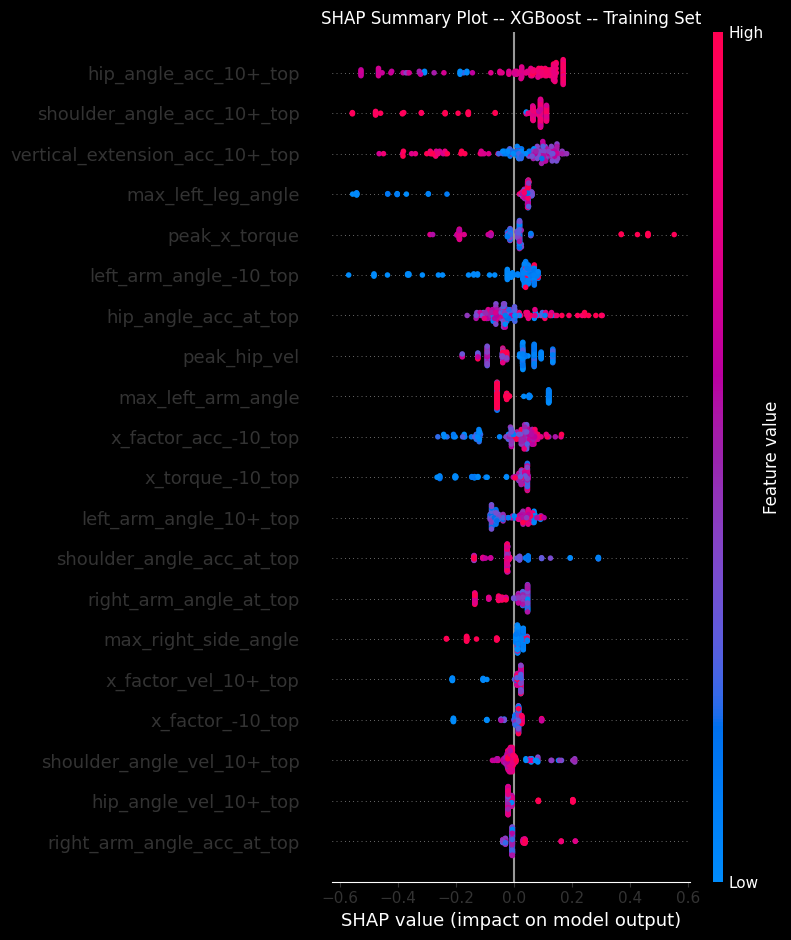

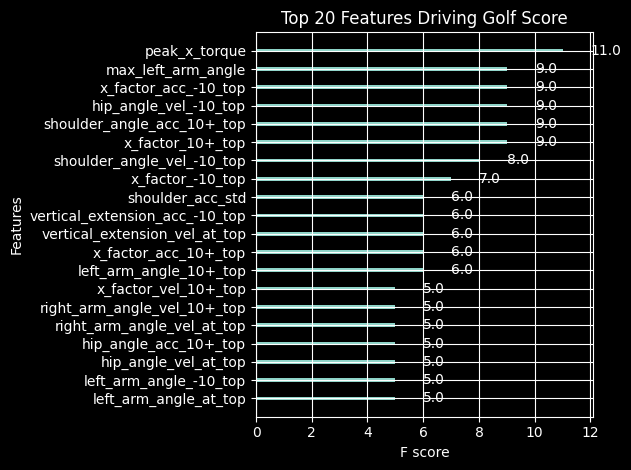

In [26]:
run_xgb(train_x, 
        train_y, 
        test_x,
        test_y,
        n_estimators=1000,           # Increased: Lower learning rate requires more trees
        learning_rate=0.25,          # Reduced significantly: Prevents rapid overfitting
        max_depth=3,                 # Reduced: 2-3 is ideal for small data to force simple logic
        min_child_weight=5,          # Critical: Requires ~4 samples to create a leaf (reduces noise)
        gamma=0.2,                   # Conservative: Minimum loss reduction required to make a split
        subsample=0.9,               # Randomness: Use only 70% of rows per tree
        colsample_bytree=0.9,        # Randomness: Use only 70% of features per tree
        #reg_lambda=1.0,              # L2 Regularization (default is 1, maybe increase to 2-3 if needed)
        early_stopping_rounds=50,    # Stop if validation score doesn't improve
        random_state=42)

In [452]:

# 1. Initialize (Note: No learning_rate in RF)
#rf_model = RandomForestClassifier(
rf_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=5,             # very shallow
    min_samples_leaf=3,      # each leaf has at least 5 swings
    max_features="sqrt",     # or even a small int
    random_state=0,
    n_jobs=-1,
    oob_score=True
)

# 2. Fit (Same syntax)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, max_features='sqrt', min_samples_leaf=3,
                      n_estimators=500, n_jobs=-1, oob_score=True,
                      random_state=0)

In [453]:
# def train_rf(n_estimators=500, 
#              max_depth=8, 
#              min_samples_leaf=10,
#              max_samples=0.7,
#              max_features='sqrt',
#             ):
#     rf_model = RandomForestRegressor(
#         n_estimators=n_estimators,
#         max_depth=max_depth,   # RFs often grow full trees by default
#         min_samples_leaf=min_samples_leaf,
#         max_features=max_features, # Crucial hyperparameter for RF
#         random_state=42
#     )
#     # 2. Fit (Same syntax)
#     rf_model.fit(X_train, y_train)
#     y_pred = rf_model.predict(X_test)
    
#     mae = mean_absolute_error(y_test, y_pred)
#     r2 = r2_score(y_test, y_pred)
#     return mae, r2

In [454]:
# import itertools
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_absolute_error, r2_score

# # 1. Define your lists of parameters to test
# n_estimators_list = [50, 100, 200, 500]
# max_depth_list = [4, 8, 12, 20, None]  # 'None' lets it grow forever (careful!)
# min_samples_leaf_list = [1, 5, 10, 20]

# results = []

# print(f"Starting training on {len(n_estimators_list) * len(max_depth_list) * len(min_samples_leaf_list)} combinations...")

# # itertools.product creates a cartesian product of input iterables
# for n_est, depth, min_samples in itertools.product(n_estimators_list, max_depth_list, min_samples_leaf_list):
    
#     # Run your training function
#     # Note: Ensure X_train, y_train, etc., are defined in your environment before running this
#     mae, r2 = train_rf(n_est, depth, min_samples)
    
#     # Print progress (optional)
#     #print(f"Params: [n={n_est}, depth={depth}, leaf={min_samples}] -> MAE: {mae:.4f}, R2: {r2:.4f}")
    
#     # Save result
#     results.append({
#         'n_estimators': n_est,
#         'max_depth': depth,
#         'min_samples_leaf': min_samples,
#         'MAE': mae,
#         'R2': r2
#     })

# # 4. Convert to DataFrame for analysis
# results_df = pd.DataFrame(results)

# # 5. Sort by Best Performance (Lowest MAE or Highest R2)
# best_results = results_df.sort_values(by='R2', ascending=False)

# print("\nTop 5 Parameter Combinations:")
# print(best_results.head(5))

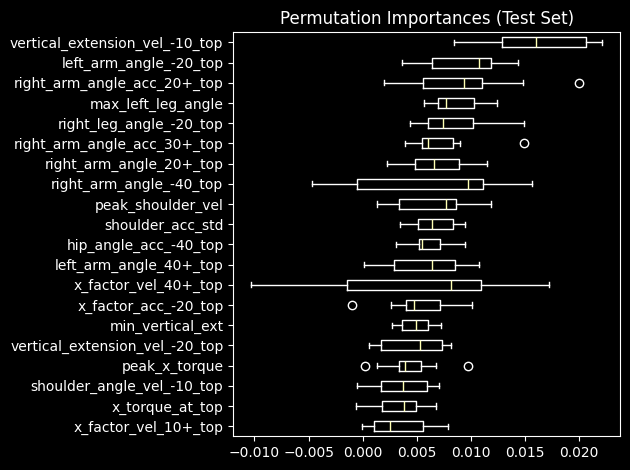

In [455]:
result = permutation_importance(
    rf_model, X_test, y_test, 
    n_repeats=10, 
    random_state=42, 
    n_jobs=-1
)

# Sort indices by mean importance
sorted_idx = result.importances_mean.argsort()[-20:] # Top 20

plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False, 
    tick_labels=np.array(feature_cols)[sorted_idx]
)
plt.title("Permutation Importances (Test Set)")
plt.tight_layout()
plt.show()

Model Performance -- Test Set:
Mean Absolute Error (MAE): 1.0456
R-squared Score (R2):      0.0492
Model Performance -- Training Set:
Mean Absolute Error (MAE): 0.7861
R-squared Score (R2):      0.6032


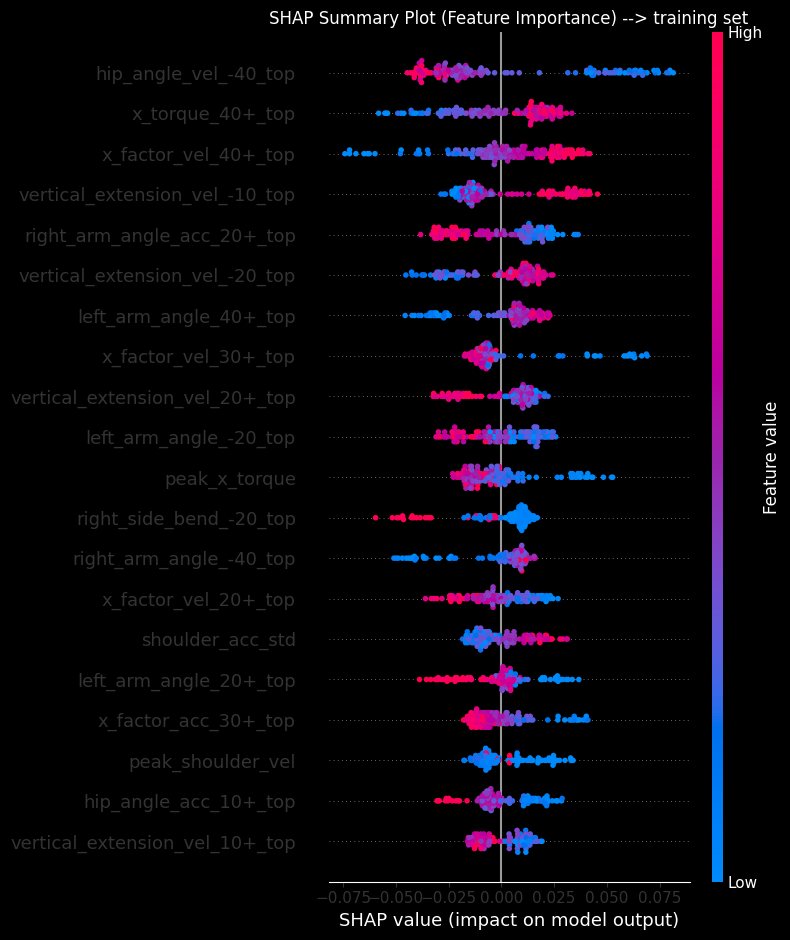

In [456]:
#Validation set
y_pred = rf_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Model Performance -- Test Set:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared Score (R2):      {r2:.4f}")

#Train Results
y_pred = rf_model.predict(X_train)
mae = mean_absolute_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)

print("Model Performance -- Training Set:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared Score (R2):      {r2:.4f}")

# 5. SHAP Visualization
# Initialize the TreeExplainer (optimized for Random Forests)
explainer = shap.TreeExplainer(rf_model)

# Calculate SHAP values for the test set
# Note: If your dataset is very large, you can pass a sample (e.g., X_test.sample(100)) to speed this up
#shap_values = explainer(X_test)
shap_values = explainer(X_train)

# Create the summary plot (Beeswarm plot)
plt.figure()
plt.title("SHAP Summary Plot (Feature Importance) --> training set")
shap.summary_plot(shap_values, X_train, show=False)
plt.show()

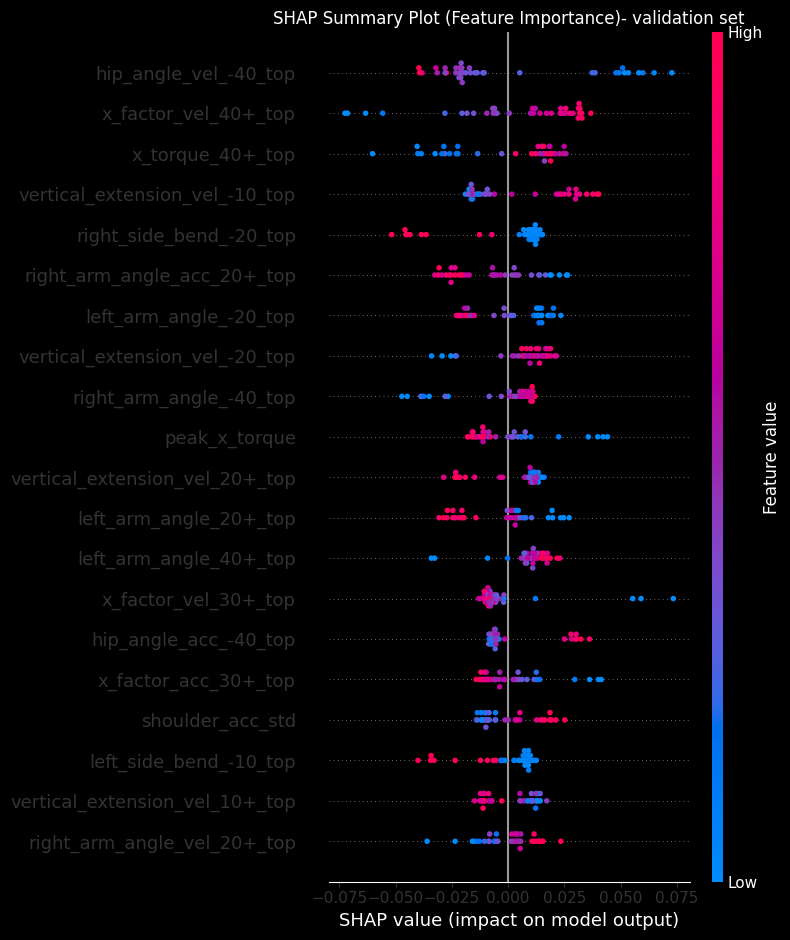

In [457]:
shap_values = explainer(X_test)

# Create the summary plot (Beeswarm plot)
plt.figure()
plt.title("SHAP Summary Plot (Feature Importance)- validation set")
shap.summary_plot(shap_values, X_test, show=False)
#shap.summary_plot(shap_values, X_train, show=False)
plt.show()

In [26]:
import numpy as np
import pandas as pd
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score

# IMPORTANT: ElasticNet requires feature scaling (RF doesn't)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ElasticNetCV automatically tunes alpha (regularization strength) and l1_ratio
# l1_ratio: 0 = Ridge (L2), 1 = Lasso (L1), 0.5 = balanced ElasticNet
elastic_cv = ElasticNetCV(
    l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0],  # Mix of L1/L2
    alphas=np.logspace(-4, 1, 50),                    # Regularization strengths
    cv=5,                                             # 5-fold cross-validation
    max_iter=10000,
    random_state=42,
    n_jobs=-1
)

# Fit the model
elastic_cv.fit(X_train_scaled, y_train)

# Predictions
y_train_pred = elastic_cv.predict(X_train_scaled)
y_test_pred = elastic_cv.predict(X_test_scaled)

# Performance metrics
print("=" * 50)
print("ElasticNet Model Performance")
print("=" * 50)
print(f"Best alpha (regularization): {elastic_cv.alpha_:.6f}")
print(f"Best l1_ratio: {elastic_cv.l1_ratio_:.2f}")
print()
print("Test Set:")
print(f"  MAE: {mean_absolute_error(y_test, y_test_pred):.4f}")
print(f"  R²:  {r2_score(y_test, y_test_pred):.4f}")
print()
print("Training Set:")
print(f"  MAE: {mean_absolute_error(y_train, y_train_pred):.4f}")
print(f"  R²:  {r2_score(y_train, y_train_pred):.4f}")

# Feature coefficients (interpretable!)
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'feature_{i}' for i in range(X_train.shape[1])]
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': elastic_cv.coef_
}).sort_values('coefficient', key=abs, ascending=False)

print()
print("Top 10 Features by Coefficient Magnitude:")
print("-" * 40)
for idx, row in coef_df.head(10).iterrows():
    print(f"  {row['feature']:35s} {row['coefficient']:+.4f}")

# Count non-zero coefficients (feature selection via L1)
n_nonzero = np.sum(elastic_cv.coef_ != 0)
print(f"\nNon-zero coefficients: {n_nonzero} / {len(elastic_cv.coef_)}")


/home/azaidi/anaconda3/envs/fastdl/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.344e-02, tolerance: 2.500e-02
  model = cd_fast.enet_coordinate_descent(
/home/azaidi/anaconda3/envs/fastdl/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.163e-02, tolerance: 2.406e-02
  model = cd_fast.enet_coordinate_descent(
/home/azaidi/anaconda3/envs/fastdl/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consi

ElasticNet Model Performance
Best alpha (regularization): 10.000000
Best l1_ratio: 0.10

Test Set:
  MAE: 1.0772
  R²:  -0.0183

Training Set:
  MAE: 1.2368
  R²:  0.0000

Top 10 Features by Coefficient Magnitude:
----------------------------------------
  peak_shoulder_vel                   +0.0000
  x_factor_vel_20+_top                -0.0000
  vertical_extension_acc_-10_top      -0.0000
  shoulder_angle_acc_20+_top          +0.0000
  hip_angle_vel_20+_top               +0.0000
  hip_angle_acc_20+_top               -0.0000
  right_arm_angle_vel_20+_top         +0.0000
  right_arm_angle_acc_20+_top         -0.0000
  x_factor_acc_20+_top                -0.0000
  shoulder_angle_vel_10+_top          -0.0000

Non-zero coefficients: 0 / 137


/home/azaidi/anaconda3/envs/fastdl/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.785e-01, tolerance: 2.393e-02
  model = cd_fast.enet_coordinate_descent(
/home/azaidi/anaconda3/envs/fastdl/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.540e-01, tolerance: 2.406e-02
  model = cd_fast.enet_coordinate_descent(
/home/azaidi/anaconda3/envs/fastdl/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consi